In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import time
import os
import copy
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def balanced_weights(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = float(nclasses)/(N*float(count[i]))                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight

def sampler(dataset):
    weights = balanced_weights(dataset.imgs, len(dataset.classes))                                                                
    weights = torch.DoubleTensor(weights)                                       
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
    return sampler

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # NO transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # NO transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
#sampler=sampler(image_datasets[x])  shuffle=True
data_dir = 'train_processed'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                        shuffle=True, num_workers=10)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    tr_loss, tr_acc, val_loss, val_acc = {},{},{},{}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                tr_loss[epoch] = epoch_loss
                tr_acc[epoch] = float(epoch_acc)
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = float(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            time_elapsed = time.time() - since
            print('Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, tr_loss, tr_acc, val_loss, val_acc

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
fc = nn.Sequential(
                nn.Linear(num_ftrs, 256),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, 85)
            )

model_ft.fc = fc #nn.Linear(num_ftrs, 85)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
model_ft, tr_loss, tr_acc, val_loss, val_acc = train_model(model_ft,
                                                           criterion, 
                                                           optimizer_ft, 
                                                           exp_lr_scheduler,
                                                           num_epochs=10)

Epoch 0/9
----------
train Loss: 3.3491 Acc: 0.2330
Time: 5m 57s
validation Loss: 2.6588 Acc: 0.3480
Time: 7m 30s

Epoch 1/9
----------
train Loss: 2.4540 Acc: 0.3808
Time: 13m 29s
validation Loss: 2.1854 Acc: 0.4295
Time: 15m 4s

Epoch 2/9
----------
train Loss: 2.0907 Acc: 0.4516
Time: 21m 7s
validation Loss: 1.9488 Acc: 0.4795
Time: 22m 42s

Epoch 3/9
----------
train Loss: 1.8502 Acc: 0.4997
Time: 28m 39s
validation Loss: 1.8193 Acc: 0.5046
Time: 30m 13s

Epoch 4/9
----------
train Loss: 1.6565 Acc: 0.5440
Time: 36m 4s
validation Loss: 1.7162 Acc: 0.5302
Time: 37m 38s

Epoch 5/9
----------
train Loss: 1.4947 Acc: 0.5820
Time: 43m 33s
validation Loss: 1.6645 Acc: 0.5446
Time: 45m 4s

Epoch 6/9
----------
train Loss: 1.3440 Acc: 0.6202
Time: 50m 60s
validation Loss: 1.6457 Acc: 0.5500
Time: 52m 31s

Epoch 7/9
----------
train Loss: 1.1592 Acc: 0.6697
Time: 58m 24s
validation Loss: 1.6100 Acc: 0.5602
Time: 59m 55s

Epoch 8/9
----------
train Loss: 1.1291 Acc: 0.6752
Time: 65m 52s
vali

In [11]:
from  sklearn.metrics import *
def accuracy_prec_recall_final(model, loader, n_classes=85):
    num_classes = n_classes
    precision = []
    recall = []
    t = time.time()
    model.eval()
    for data in loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        cur_recall = recall_score(labels.cpu().data.numpy(),predicted.cpu().data.numpy(),average='weighted')
        recall.append(cur_recall)
        cur_precision = precision_score(labels.cpu().data.numpy(),predicted.cpu().data.numpy(),average='weighted')
        precision.append(cur_precision)
    avg_prec = np.asarray(precision).mean()
    avg_recall = np.asarray(recall).mean()
    print(f"Time end: {(time.time() - t):.1f}s")
    print(f"Average precision of the network: {round(avg_prec*100,2)}%")
    print(f"Average recall of the network: {round(avg_recall*100,2)}%")
    return precision, recall 

In [12]:
pr, rec = accuracy_prec_recall_final(model_ft, dataloaders['validation'])

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Time end: 86.2s
Average precision of the network: 54.85%
Average recall of the network: 56.26%


In [11]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
columns_a = ['epochs','accuracy']
columns_l = ['epochs','loss']

df_tr_loss = pd.Series(tr_loss).to_frame('new_col').reset_index()
df_tr_loss.columns=columns_l

df_tr_acc = pd.Series(tr_acc).to_frame('new_col').reset_index()
df_tr_acc.columns=columns_a

df_val_loss = pd.Series(val_loss).to_frame('new_col').reset_index()
df_val_loss.columns=columns_l

df_val_acc = pd.Series(val_acc).to_frame('new_col').reset_index()
df_val_acc.columns=columns_a

In [8]:
print(tr_acc)
print(tr_loss)
print(tr_loss)
print(val_loss)

{0: 0.23302626760970532, 1: 0.38075507332960745, 2: 0.45157933280656787, 3: 0.4996723775752086, 4: 0.5440266723197594, 5: 0.5819923297808784, 6: 0.620150706315404, 7: 0.6697084160419357, 8: 0.6751623658193452, 9: 0.6827169534968875}
{0: 3.349094682720425, 1: 2.4540304613737374, 2: 2.09070119205513, 3: 1.8502210960759626, 4: 1.656507720556985, 5: 1.4946579892043217, 6: 1.3440389635246361, 7: 1.1591612833905232, 8: 1.129094537253434, 9: 1.1046252959692007}
{0: 3.349094682720425, 1: 2.4540304613737374, 2: 2.09070119205513, 3: 1.8502210960759626, 4: 1.656507720556985, 5: 1.4946579892043217, 6: 1.3440389635246361, 7: 1.1591612833905232, 8: 1.129094537253434, 9: 1.1046252959692007}
{0: 2.6588440458093188, 1: 2.185357854614628, 2: 1.9488345215217837, 3: 1.819320157180635, 4: 1.7162272509866117, 5: 1.6645374029458935, 6: 1.645721330077304, 7: 1.6099711367255158, 8: 1.6104007051901097, 9: 1.6151921003034493}


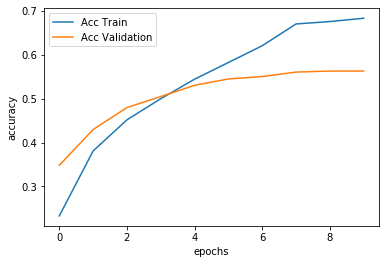

In [9]:
sns.lineplot(x=df_tr_acc.epochs, y=df_tr_acc.accuracy, label='Acc Train');
ax=sns.lineplot(x=df_val_acc.epochs, y=df_val_acc.accuracy, label='Acc Validation');

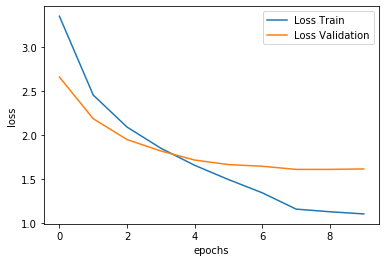

In [10]:
sns.lineplot(x=df_tr_loss.epochs, y=df_tr_loss.loss, label='Loss Train');
ax=sns.lineplot(x=df_val_loss.epochs, y=df_val_loss.loss, label='Loss Validation');